In [5]:
import xarray as xr
import matplotlib.pyplot as plt
from stompy.grid import unstructured_grid
from stompy import utils
import numpy as np
import os
%matplotlib notebook

In [6]:
from stompy.grid import multi_ugrid
import six
six.moves.reload_module(multi_ugrid)

<module 'stompy.grid.multi_ugrid' from '/home/rusty/src/stompy/stompy/grid/multi_ugrid.py'>

In [4]:
mu=multi_ugrid.MultiUgrid(paths="run_salt_20160520-v91/DFM_OUTPUT_flowfm/*_map.nc",
                          cleanup_dfm=True)
#                         xr_kwargs=dict(decode_times=False))

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [ ]:
ds=mu.dss[0]

In [ ]:
mu.reload()
print("Evolution of timesteps")
mu.dss[0].timestep

In [ ]:
# Diagnosing CFL constraints at flow control structure

In [ ]:
# First find the bad cell, so we can figure out which time
# step to focus on
plt.figure()
#mu.grid.plot_cells(values=mu['s1'].isel(time=-1),cmap='turbo',clim=[1.55,1.60])
mu.grid.plot_cells(values=mu['mesh2d_Numlimdt'].isel(time=-1),cmap='turbo')

plt.axis('tight')
plt.axis('equal')

plt.axis( (552551.266464832, 552612.551966955, 4124419.5659065135, 4124465.2334903535) )


In [ ]:
c=mu.grid.select_cells_nearest([552589,4124432],inside=True)

In [ ]:
# edge mapping appears to be broken.


In [ ]:
mu['mesh2d_Numlimdt']

In [ ]:
plt.figure()
# So time=7 is reasonable time to check.
plt.plot( mu.time.values, mu['mesh2d_Numlimdt'].values[:,c],'g-o')

In [ ]:
mu.dss[0]

In [ ]:
time=7
layer=5

# 
flow_x=mu['mesh2d_edge_x'].values
flow_y=mu['mesh2d_edge_y'].values

unorm=mu['mesh2d_u1'].isel(time=time,mesh2d_nLayers=layer)

In [ ]:
plt.figure()
mu.grid.plot_edges(color='0.5',lw=0.5)
#mu.grid.plot_cells(values=mu['mesh2d_Numlimdt'].isel(time=-1).values-mu['mesh2d_Numlimdt'].isel(time=-2).values)
plt.axis('tight')
plt.axis('equal')
plt.axis( (552551.266464832, 552612.551966955, 4124419.5659065135, 4124465.2334903535) )

norms=mu.grid.edges_normals()
#plt.quiver( flow_x, flow_y, norms[:,0], norms[:,1], scale=25 )
plt.plot( flow_x, flow_y, 'g.')

In [ ]:
ds=mu.dss[proc]
assert ds.dims['nFlowElem']==ds.dims['nNetElem']

# Create a kdtree of NetLink centers, match to FlowLink centers.
kdt=cKDTree(data=np.c_[ds['NetLink_xu'].values,ds['NetLink_yu'].values])
dists,matches=kdt.query(np.c_[ds['FlowLink_xu'].values,ds['FlowLink_yu'].values])
assert dists.max()<1e-5 # really should be indentically 0.
f2n=matches
n2f=9999999*np.zeros(g_local.Nedges(),np.int32)
n2f[matches]=np.arange(ds.dims['nFlowLink'])

In [ ]:
g_local.cell_to_edges(c_local) # those are NetLinks
flowlinks=n2f[g_local.cell_to_edges(c_local)]
flows=mu.dss[proc].q1.isel(time=time,nFlowLink=flowlinks)
u0_edge=mu.dss[proc].u0.isel(time=time,nFlowLink=flowlinks)
u_edge=mu.dss[proc].unorm.isel(time=time,nFlowLink=flowlinks)

# So laydim 5 is the super thin one.
# It's area is 30.685 m2, with a thickness of 0.0001 m
# It has a flow of 0.006997 m3/s.
print("q1")
flows.to_dataframe()['q1'].unstack('nFlowLink')

In [ ]:
fig,ax=plt.subplots(1,1)
g_local.plot_edges(color='0.6',lw=0.4,alpha=0.5)
g_local.plot_cells(mask=[c_local],alpha=0.4)
g_local.plot_edges(mask=g_local.cell_to_edges(cell),color='tab:blue')
plt.plot(flows.FlowLink_xu,flows.FlowLink_yu,'ro') # lines up. good.

# nodes=np.r_[350,356]-1
g_local.plot_nodes(clip=zoom,labeler=lambda i,rec: f"{ds['NetNode_z'].isel(nNetNode=i).values:.4f}",
                   sizes=5)
# g_local.plot_nodes(mask=nodes,color='g')
pad=8
zoom=[cell_center[0]-pad,cell_center[0]+pad,
      cell_center[1]-pad,cell_center[1]+pad]
ds=mu.dss[proc]
g_local.plot_cells(labeler=lambda c,rec: f"{ds['FlowElem_bl'].isel(nFlowElem=c).values:.4f}",
                   clip=zoom,color='none')
ax.axis(zoom)



In [ ]:
# With bedlevtype=6, the node means gave the cell bl,
# and roughly it appeared that the average of the two
# cell bl gave the edge depth.
# np.mean([1.0184,1.0655,1.4509,1.4647]) # 1.24987
# np.mean([0.9179,1.0184,1.0655,0.9492]) # 0.9878
# 1.25-np.mean([0.9877,1.2499]) # 0.1312

# With bedlevtyp=5, looks like edges get the shallower of 
# the nodes, and cells get the deepest of the edges. that
# sounds safer.



# unorm and q1 implied this to be 
# dz=0.1346577

# Those are similar, but not within the realm of simple
# rounding error. The difference could be due to time
# staggering, if q1 is an integrated quantity and unorm
# is instantaneous. checked against integration from u0
# to unorm, but that is too small. Still, q1 could be 
# integrated from the previuos map output, or previous
# user timestep.

In [ ]:
(mu.FlowElem_bl.values % 0.25).max()

In [ ]:
ds['ucx'].isel(time=6,nFlowElem=cell)
(ds['timestep']/np.timedelta64(1,'s')).to_dataframe()

In [ ]:
A=g11.cells_area(cell)
dz=1.25-ds['FlowElem_bl'].values[cell]
A*dz # 0.003 m3.
A*dz / 0.009 # CFL=1.0 for dt=0.35 s, at time=5 (goes nan at time=6)

In [ ]:
g11.cells_center()[cell]

In [ ]:
flows.isel(laydim=5,nFlowLink=3), u_edge.isel(laydim=5,nFlowLink=3)

In [ ]:
# Testing for consistency of layer thickness.
A_hor = (flows/u_edge).isel(laydim=5,nFlowLink=3)
A_hor # 0.9576 m2.
# This edge should be about 7m long.
# This doesn't square. That would make the thickness of the
# flux face 
# A_hor.values/g11.edges_length(g11.cell_to_edges(cell)[3])
# = 0.1346577m.
# Based on the bedlevel and the layer interfaces, it should be
# 0.0001 m thick.
# Check back on bedlevtype=6 and the adjacent node values.
# Adjacent node values if used directly would give 1.06 to 1.08
#ds['ww1'].isel(time=5,nFlowElem=cell,wdim=6).values * A / (u_edge.isel(laydim=5,nFlowLink=3).values

In [ ]:
j_length=g11.edges_length(g11.cell_to_edges(cell)[3])

dz_est=(flows/u_edge).isel(laydim=5,nFlowLink=3).values/j_length
dz_est

In [ ]:
netlinks=g11.cell_to_edges(cell)
netlinks,flowlinks
jnet=netlinks[3]
nodes=ds.NetLink.isel(nNetLink=jnet).values # 1-based, NetNode 350 356, confirms with NetElemNode[cell]

ds.NetNode_z.isel(nNetNode=nodes-1)
# That gives 1.0183, 1.0655.

ds.FlowElem_zcc.isel(nFlowElem=cell) # depth matching elevation of FlowElem_bl

In [ ]:
ds

In [ ]:
ds.

In [ ]:
recs=[]

if 'laydim' in mu.dims:
    nlayer=mu.dims['laydim']
    layer_kw={'laydim':0}
else:
    layer_kw={}
    nlayer=0
    
salt_thresh=34
for t in utils.progress(range(mu.dss[0].dims['time'])):
    if nlayer<2:
        t_max=np.max(mu['tem1'].isel(time=t,**layer_kw))
        s_max=np.max(mu['sa1'].isel(time=t,**layer_kw))
        # print(f"t={t:4d}:  max T={t_max:8.3f}  max s={s_max:8.3f}")
        excess_salt=( (mu['sa1'].isel(time=t,**layer_kw).values-salt_thresh).clip(0) 
                      * mu['waterdepth'].isel(time=t) * mu['FlowElem_bac']).sum()
    else:
        # proper 3D 
        wet=np.isfinite(mu['ucx'].isel(time=t).values)
        T=mu['tem1'].isel(time=t).values
        t_max=T[wet].max()
        salt=mu['sa1'].isel(time=t).values
        s_max=salt[wet].max()
        # print(f"t={t:4d}:  max T={t_max:8.3f}  max s={s_max:8.3f}")
        excess_salt=0.0 # not ready for this calc 
    recs.append(dict(t=t,T_max=t_max,s_max=s_max,excess_salt=excess_salt))


In [ ]:
import pandas as pd
df=pd.DataFrame(recs)

fig,axs=plt.subplots(2,1,sharex=True)

axs[0].plot(df.t,df.T_max,label='T max')
axs[0].plot(df.t,df.s_max,label='s max')
axs[0].legend()

axs[1].plot(df.t,df.excess_salt,label='Excess salt (kg)')
axs[1].legend()

In [ ]:
# Try to infer z layer structure:

# We have bedlevel, water level, nan ucx in cells below the bed,
# and I think also for cells above the water surface.

t=2

nlayers=mu.dims['laydim']
dzmin=np.inf

z_laymaxs=np.inf*np.ones(nlayers) # upper limit of layer

all_ucx=mu['ucx'].isel(time=t).values
all_s1=mu['s1'].isel(time=t).values
all_bl=mu['FlowElem_bl'].values

for c in utils.progress(range(mu.grid.Ncells())):
    s1=all_s1[c]
    bl=all_bl[c]
    dzmin=min(dzmin,s1-bl)

    wet_layers=np.isfinite(all_ucx[c,:])

    # This watercolumn bed is at 0.2793.
    # and the bottom 4 layers are empty.
    # so the upper interface of layer=3 is not above
    # 0.2793.
    z_laymaxs[~wet_layers]=np.minimum(z_laymaxs[~wet_layers],bl)

# That seems to work okay. Get interface locations, and nothing
# for the top of the last layer.
z_laymaxs

In [ ]:
dz=np.median(np.diff(z_laymaxs))
z_bot=z_laymaxs[0]-dz
z_top=z_laymaxs[-2]+dz
print(f"Inferred dz={dz:.5f}  z_bot={z_bot:.4f}   z_top={z_top:.4f}")
# That z_bot is pretty close to the deepest cell in the domain at 
# -0.22637 m, and the z_top is the initial water level
# of 1.4981

In [ ]:
mu.reload()

In [ ]:
plt.figure()

#mu.grid.plot_edges(lw=0.5,color='k',alpha=0.4)
ccoll=mu.grid.plot_cells(values=mu['sa1'].isel(time=-1),cmap='turbo')
plt.colorbar(ccoll)
plt.axis('off')
plt.axis('tight')
plt.axis('equal')
#plt.axis((551938.0292926112, 552765.2786743934, 4124006.5426040255, 4124777.0853749597))

In [ ]:
# What?! his file is now split across domains?
his_fn=os.path.join( os.path.dirname(mu.paths[0]), 'flowfm_0000_his.nc')

In [ ]:
his_ds=xr.open_dataset(his_fn)

In [ ]:
his_ds

In [ ]:
# History file has more information on z coordinates
# zcoordinate_c gives elevation of the vertical center
# of the layers, on a time and cell basis.
his_ds.zcoordinate_w.isel(time=4,stations=5)

In [ ]:
mu.paths[0]

In [ ]:
# See if there is useful crash data in the last restart file
p=0
ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')

In [ ]:
ds

In [ ]:
ds.timestep.values/np.timedelta64(1,'s') # 0.00033 s
# squ is the cell-centerd outgoing flux.  seems useful.

In [ ]:
squ[squ==-999]=np.nan

In [ ]:
np.nanmax(squ),np.nanmin(squ) # 0.2822, 0.0

In [ ]:
# Calculate 2D CFL #s
plt.figure()
colls=[]
for p in range(len(mu.paths)):
    print(p)
    ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')
    g_p=unstructured_grid.UnstructuredGrid.read_ugrid(mu.dss[p])
    squ=ds.squ.values[0,:,:] # cell, wdim
    squ_zsum=np.sum(squ.clip(0),axis=1)
    # colls.append( g_p.plot_cells(values=squ_zsum,cmap='turbo',clim=[0,10]) )
    # normalize by cell area:
    Ac=g_p.cells_area()
    dz=ds.s1.values[0,:] - ds.FlowElem_bl.values[0,:]
    Vc=Ac*dz
    t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
    colls.append( g_p.plot_cells(values=t_max,cmap='turbo',clim=[0,2]) )
    print("Min(t_max):",t_max.min())
    ds.close()

plt.colorbar(colls[0],label='t max (s)')
plt.axis('tight')
plt.axis('equal')

In [ ]:
# Survey vertical velocity
plt.figure()
colls=[]
for p in range(len(mu.paths)):
    print(p)
    ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')
    g_p=unstructured_grid.UnstructuredGrid.read_ugrid(mu.dss[p])
    ww1=ds.ww1.isel(time=0).values # element, wdim
    ww1[ww1==-999]=np.nan
    w_absmax=np.nanmax(np.abs(ww1),axis=1)
    colls.append( g_p.plot_cells(values=w_absmax,cmap='turbo',clim=[0,0.02]) )
    print("max w_absmax:",w_absmax.max())
    # surface layer thickness
    dz_surf=ds.s1.isel(time=0).values %0.25
    max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
    print("min dt_max vertical (conservative): ",min(max_dt_vert))
    ds.close()

plt.colorbar(colls[0],label='max |w| (m/s)')
plt.axis('tight')
plt.axis('equal')

In [ ]:
# Survey vertical viscosity
for p in range(len(mu.paths)):
    print(p)
    ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')
    vicwwu=ds.vicwwu.isel(time=0).values # flowlink, wdim
    print("max vicwwu:",np.nanmax(vicwwu))
    ds.close()


In [9]:
# What's up with the deep bias runs?  Why so unstable?
ds=xr.open_dataset('run_salt_20160520-v98/pesca_butano_existing_deep_bathy_net.nc')

In [10]:
g=unstructured_grid.UnstructuredGrid.read_dfm(ds)

In [16]:
g.Nedges()

116116

In [ ]:
np.any( g.edge_to_cells()<0, axis=1).sum()

<IPython.core.display.Javascript object>


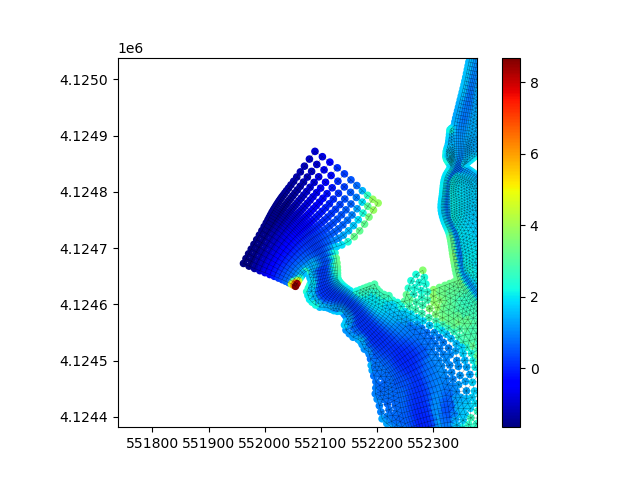

In [15]:
plt.figure()
g.plot_edges(color='k',lw=0.4,alpha=0.4)
ncoll=g.plot_nodes(values=g.nodes['depth'],cmap='jet')
plt.colorbar(ncoll)

In [8]:
ls run_salt_20160520-v98

butano_ck_0001.tim
butano_ck.pli
butano_ck_salinity_0001.tim
butano_ck_salinity.pli
butano_ck_temperature_0001.tim
butano_ck_temperature.pli
DFM_interpreted_idomain_pesca_butano_existing_deep_bathy_net.nc
DFM_OUTPUT_flowfm/
flowfm_0000.mdu
flowfm_0001.mdu
flowfm_0002.mdu
flowfm_0003.mdu
flowfm_0004.mdu
flowfm_0005.mdu
flowfm_0006.mdu
flowfm_0007.mdu
flowfm_0008.mdu
flowfm_0009.mdu
flowfm_0010.mdu
flowfm_0011.mdu
flowfm_0012.mdu
flowfm_0013.mdu
flowfm_0014.mdu
flowfm_0015.mdu
FlowFM.ext
flowfm.mdu
matrix_0000.m
matrix_0001.m
matrix_0002.m
matrix_0003.m
matrix_0004.m
matrix_0005.m
matrix_0006.m
matrix_0007.m
matrix_0008.m
matrix_0009.m
matrix_0010.m
matrix_0011.m
matrix_0012.m
matrix_0013.m
matrix_0014.m
matrix_0015.m
mouth_in_CrestLevel.tim
mouth_in_GateOpeningWidth.tim
mouth_in.pli
mouth_out_CrestLevel.tim
mouth_out_GateOpeningWidth.tim
mouth_out.pli
nmc_gate.pli
nm_ditch_gate.pli
obs_points.xyn
obs_sections.pli
ocean_bc_0001.tim
ocean_bc.pli
ocean_bc_salinity_0001.tim
ocean_bc_salinit